In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.keras import TqdmCallback
import glob
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import KFold
import tensorflow as tf
from sklearn import preprocessing
from collections import Counter
from numpy import where
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold
import keras.backend as K
import scipy

os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

In [ ]:
output_path = "/content/drive/MyDrive/labelled data/"

#omit participant p02, p18 and p20
participants = ["p" + str(i).zfill(2) for i in range(0, 25) if i != 2 and i != 18 and i != 20]
print(participants)

['p00', 'p01', 'p03', 'p04', 'p05', 'p06', 'p07', 'p08', 'p09', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p19', 'p21', 'p22', 'p23', 'p24']


# **Pre-processing with StandardScaler()**

In [ ]:
def s(samples):
    std = np.std(samples)
    if std == 0:
        return samples - np.mean(samples)
    else:
        return (samples - np.mean(samples)) / std

def preprocess(df):
  scaler = preprocessing.StandardScaler() #MinMaxScaler
  names = df.columns
  fit = scaler.fit_transform(df)
  scaled_df = pd.DataFrame(fit, columns=names)
  return scaled_df

# **Segmentation with window size 30 (without overlap)**

**All features sampled at 4Hz**

In [ ]:
eda_freq = 4

#without overlap
def get_data(pid):

    for f in os.listdir(output_path):
        if f.startswith(str(pid)) and f.endswith("EDA.csv"):
            eda_path = f
        elif f.startswith(str(pid)) and f.endswith("TEMP.csv"):
            temp_path = f
        elif f.startswith(str(pid)) and f.endswith("BVP.csv"):
            bvp_path = f
        elif f.startswith(str(pid)) and f.endswith("HR.csv"):
            hr_path = f
        elif f.startswith(str(pid)) and f.endswith("ACC.csv"):
            acc_path = f

    eda_data_raw = pd.read_csv(output_path + eda_path)
    temp_data_raw_all = pd.read_csv(output_path + temp_path)
    bvp_data_raw_all = pd.read_csv(output_path + bvp_path)
    hr_data_raw_all = pd.read_csv(output_path + hr_path)
    acc_data_raw_all = pd.read_csv(output_path + acc_path)

    bvp_data_raw_arr = scipy.signal.resample(bvp_data_raw_all['bvp'], len(eda_data_raw['eda']))
    temp_data_raw_arr = scipy.signal.resample(temp_data_raw_all['temp'], len(eda_data_raw['eda']))
    hr_data_raw_arr = scipy.signal.resample(hr_data_raw_all['bpm'], len(eda_data_raw['eda']))
    acc_x_data_raw_arr = scipy.signal.resample(acc_data_raw_all['x'], len(eda_data_raw['eda']))
    acc_y_data_raw_arr = scipy.signal.resample(acc_data_raw_all['y'], len(eda_data_raw['eda']))
    acc_z_data_raw_arr = scipy.signal.resample(acc_data_raw_all['z'], len(eda_data_raw['eda']))

    df_bvp = pd.DataFrame(bvp_data_raw_arr, columns = ['bvp'])
    df_temp = pd.DataFrame(temp_data_raw_arr, columns = ['temp'])
    df_hr = pd.DataFrame(hr_data_raw_arr, columns = ['bpm'])
    df_acc_x = pd.DataFrame(acc_x_data_raw_arr, columns = ['x'])
    df_acc_y = pd.DataFrame(acc_y_data_raw_arr, columns = ['y'])
    df_acc_z = pd.DataFrame(acc_z_data_raw_arr, columns = ['z'])
    df_eda = pd.DataFrame(eda_data_raw['eda'], columns= ['eda'])

    eda_data = preprocess(df_eda)
    temp_data = preprocess(df_temp)
    bvp_data = preprocess(df_bvp)
    hr_data = preprocess(df_hr)
    acc_x_data = preprocess(df_acc_x)
    acc_y_data = preprocess(df_acc_y)
    acc_z_data = preprocess(df_acc_z)

    data_merged = pd.concat([eda_data, temp_data, bvp_data, acc_x_data, acc_y_data, acc_z_data], axis=1)

    data_as_np = data_merged.to_numpy()

    win_size = 30; X=[]; label=[];

    for i in range(win_size, int(len(eda_data_raw['eda']) / eda_freq)):

        X.append(s(data_as_np[eda_freq * (i - win_size): eda_freq * i]))

        l = eda_data_raw["label"][eda_freq * (i - win_size): eda_freq * i]
        lp = np.bincount(np.array(l)).argmax()
        label.append(lp)

    return { "data": np.array(X, dtype=object),
            "label": np.array(label)}

In [ ]:
all_data = [get_data(pid) for pid in participants]

In [ ]:
for i in range(len(all_data)):
        print(all_data[i]['data'].shape)   #(samples,120,6)
        print(all_data[i]['label'].shape)  #(samples,)

# **Kfold cross validation**

In [ ]:
def kfold(X, y, folds):

    X_train_smote, X_test, y_train_smote, y_test = {}, {}, {}, {}
    X_train, y_train = {}, {}

    cv = KFold(n_splits=folds, random_state=36851234, shuffle = True)

    X_train_all, X_test_all = [], []
    y_train_all, y_test_all = [], []

    for train_ix, test_ix in cv.split(X, y):
            X_train = X[train_ix, :].astype(np.float32)
            X_test = X[test_ix, :].astype(np.float32)
            y_train = y[train_ix]
            y_test = y[test_ix]

            X_train_all.append(X_train)
            X_test_all.append(X_test)

            y_train_all.append(y_train)
            y_test_all.append(y_test)

    #print(X_train_all[0].shape)
    #print(X_test_all[0].shape)
    return X_train_all, X_test_all, y_train_all, y_test_all

# **LSTM model**

In [ ]:
all_scores_lstm, all_f1_lstm = [], []

def lstm(X,y,folds):

    print("INSIDE CLASSIFIER")

    X_train, X_test, y_train, y_test = kfold(X, y, folds)

    for i in range(folds):

      models = []

      X_train_reshape, X_test_reshape = [], []

      #print(X_train[i], X_test[i], y_train[i], y_test[i])

      X_train_reshape.append(X_train[i])
      X_test_reshape.append(X_test[i])

      input = keras.layers.Input(shape=(X_train[i].shape[1], X_train[i].shape[2]))

      conv1d = keras.layers.Conv1D(32*2, 7)(input)
      lstm = keras.layers.LSTM(units=384)(conv1d)

      dense_layer_1 = keras.layers.Dense(64, activation="swish")(lstm)
      dense_layer_2 = keras.layers.Dense(100, activation="relu")(dense_layer_1)
      dropout = keras.layers.Dropout(0.05)(dense_layer_2)

      output_layer = keras.layers.Dense(3, activation="softmax")(dropout)

      model = tf.keras.Model(inputs=input, outputs=output_layer)
      print('COMPILING...')
      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'])

      history = model.fit(X_train_reshape, y_train[i], epochs=5, batch_size=128,
                         validation_data=(X_test_reshape, y_test[i]), verbose=0)

      scores = model.evaluate(X_test_reshape, y_test[i], batch_size=128, verbose=1)
      print(f'Score : {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

      all_scores_lstm.append(scores[1])

      y_pred = np.argmax(model.predict(X_test_reshape), axis=1)
      all_f1_lstm.append(f1_score(y_test[i], y_pred, average='weighted'))
      print('F1 score: ', f1_score(y_test[i], y_pred, average='weighted'))
      print('Precision: ',precision_score(y_test[i], y_pred, average='weighted'))
      print('Recall: ',recall_score(y_test[i], y_pred, average='weighted'))

      pd.DataFrame(history.history).plot(figsize=(6, 5))
      plt.show()

      cm = confusion_matrix(y_test[i], y_pred, labels=[0,1,2])
      print(cm)
      ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap='Reds')
      ax.figsize=(5,5)
      ax.set_title('Confusion Matrix\n\n');
      ax.set_xlabel('\nPredicted Values')
      ax.set_ylabel('Actual Values ');

      ax.xaxis.set_ticklabels(['0','1','2'])
      ax.yaxis.set_ticklabels(['0','1','2'])

      plt.show()

**LSTM results**

INSIDE CLASSIFIER
COMPILING...
32/32 [==============================] - 0s 8ms/step - loss: 0.5753 - accuracy: 0.7551
Score : loss of 0.5753316283226013; accuracy of 75.50567388534546%
127/127 [==============================] - 1s 3ms/step
F1 score:  0.7539770392938139
Precision:  0.7672620527559122
Recall:  0.7550567340897879


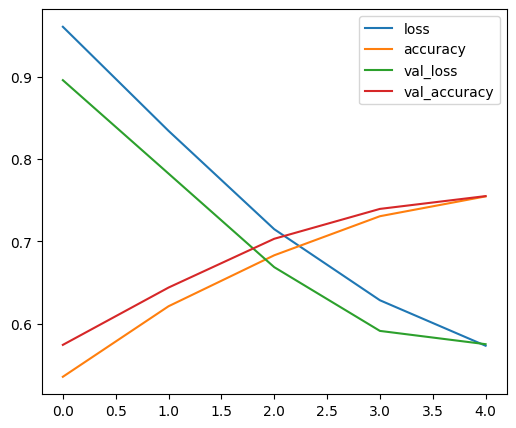

[[ 845  280  198]
 [ 112 1148  124]
 [  38  241 1068]]


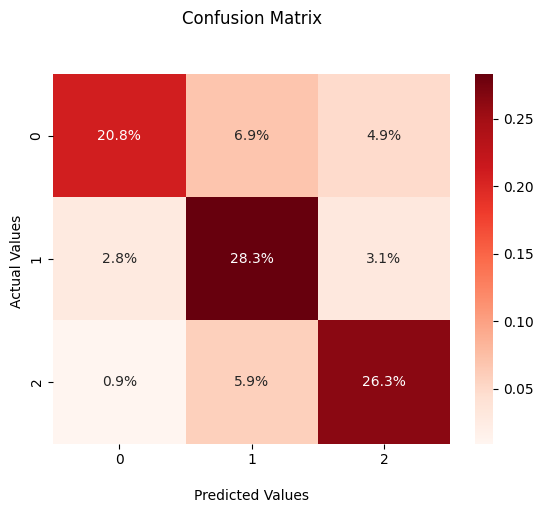

COMPILING...
32/32 [==============================] - 0s 8ms/step - loss: 0.4978 - accuracy: 0.7990
Score : loss of 0.4977720081806183; accuracy of 79.89639639854431%
127/127 [==============================] - 1s 4ms/step
F1 score:  0.7984414222235101
Precision:  0.8002130368568884
Recall:  0.7989639861864825


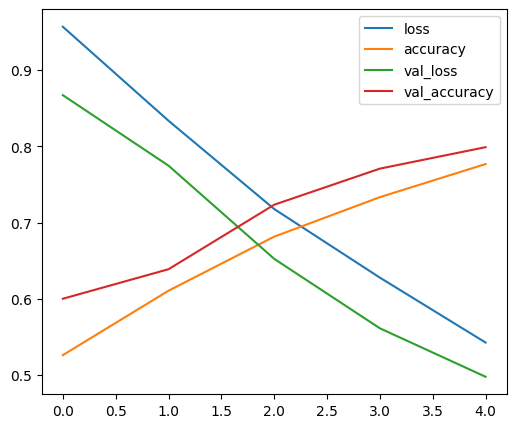

[[1066  122  143]
 [ 187 1069  176]
 [  66  121 1104]]


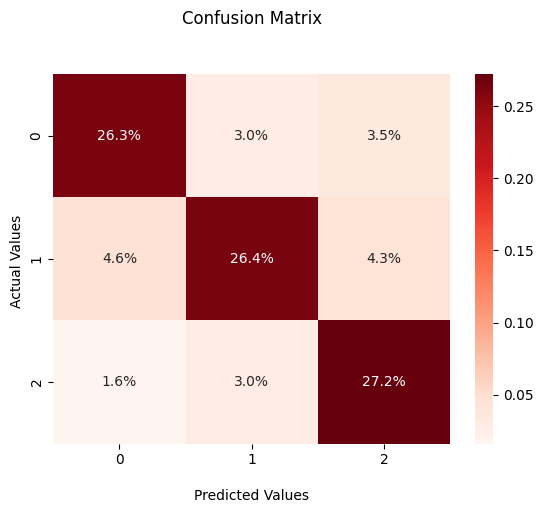

COMPILING...
32/32 [==============================] - 0s 8ms/step - loss: 0.5641 - accuracy: 0.7701
Score : loss of 0.5641093850135803; accuracy of 77.01035737991333%
127/127 [==============================] - 1s 4ms/step
F1 score:  0.7701750942827409
Precision:  0.7719082559318906
Recall:  0.7701036013813517


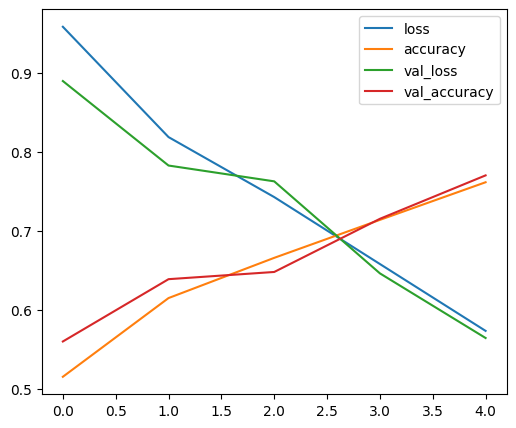

[[ 990  203  139]
 [ 162 1116  112]
 [ 116  200 1016]]


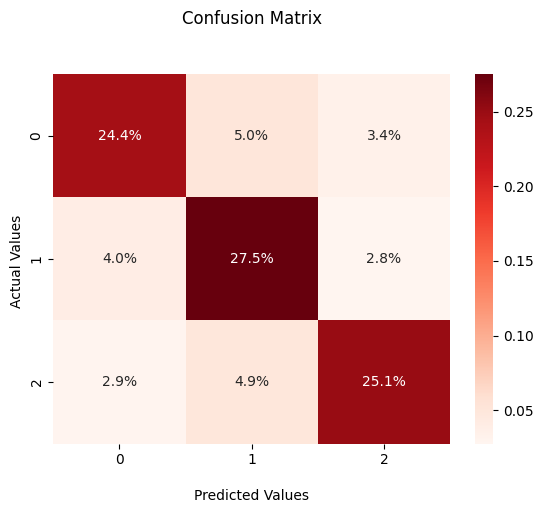

COMPILING...
32/32 [==============================] - 0s 8ms/step - loss: 0.4734 - accuracy: 0.8071
Score : loss of 0.4733644425868988; accuracy of 80.71041107177734%
127/127 [==============================] - 1s 3ms/step
F1 score:  0.8068723408019791
Precision:  0.8071263736087247
Recall:  0.807104094721263


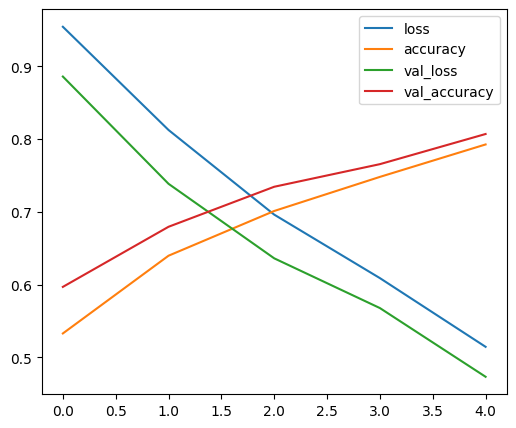

[[1115  157  123]
 [ 157 1034  144]
 [  84  117 1123]]


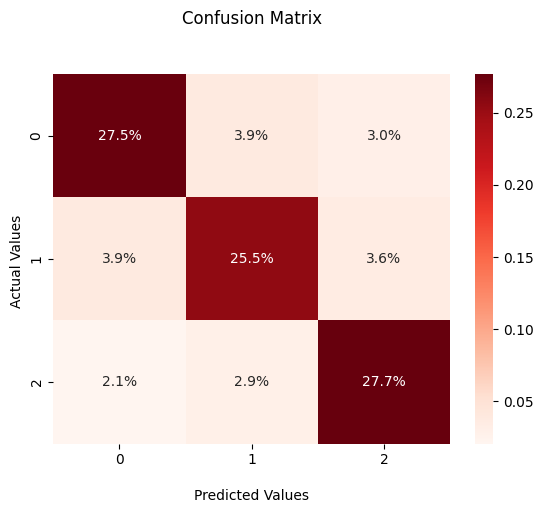

COMPILING...
32/32 [==============================] - 0s 8ms/step - loss: 0.5430 - accuracy: 0.7797
Score : loss of 0.5430442094802856; accuracy of 77.97237038612366%
127/127 [==============================] - 1s 4ms/step
F1 score:  0.7792163406597217
Precision:  0.7840665892936458
Recall:  0.7797237296497287


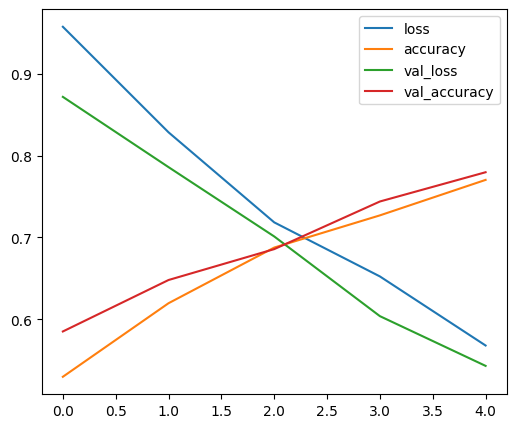

[[ 990  133  259]
 [ 159 1046  143]
 [  48  151 1125]]


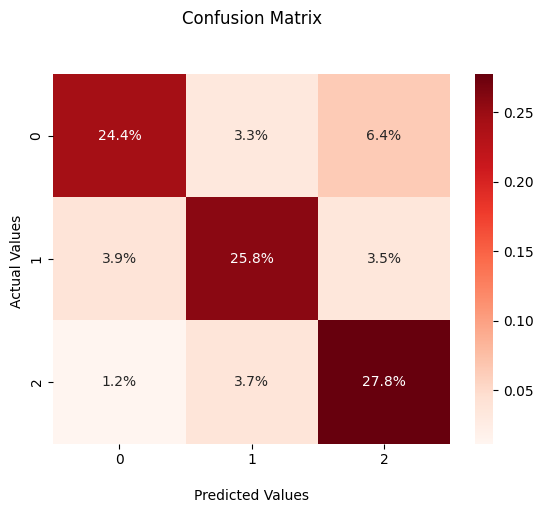

In [ ]:
X = {}
y = {}

X = np.concatenate([all_data[i]["data"] for i in range(len(all_data))])
y = np.concatenate([all_data[i]["label"] for i in range(len(all_data))])

#fcn(X, y, 5)
lstm(X,y,5)

In [ ]:
all_scores_lstm

[0.7550567388534546,
 0.7989639639854431,
 0.7701035737991333,
 0.8071041107177734,
 0.7797237038612366]

In [ ]:
np.mean(all_scores_lstm)

0.7821904182434082

In [ ]:
all_f1_lstm

[0.7539770392938139,
 0.7984414222235101,
 0.7701750942827409,
 0.8068723408019791,
 0.7792163406597217]

In [ ]:
np.mean(all_f1_lstm)

0.7817364474523532

# **Transformers model**

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [ ]:
all_scores_transf, all_f1_transf = [], []

def transformers(X,y,folds):

    print("INSIDE CLASSIFIER")

    X_train, X_test, y_train, y_test = kfold(X, y, folds)

    for i in range(folds):

      num_transformer_blocks = 2
      head_size = 256
      num_heads = 4
      dropout = 0.25
      ff_dim = 4
      mlp_units=[128]
      mlp_dropout=0.4

      models = []

      X_train_reshape, X_test_reshape = [], []

      #print(X_train[i], X_test[i], y_train[i], y_test[i])

      X_train_reshape.append(X_train[i])
      X_test_reshape.append(X_test[i])

      input = keras.layers.Input(shape=(X_train[i].shape[1], X_train[i].shape[2]))
      x = input

      for _ in range(num_transformer_blocks):
        transformer_layer = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

      pooling_layer = layers.GlobalAveragePooling1D(data_format="channels_first")(transformer_layer)

      for dim in mlp_units:
        dense_layer = layers.Dense(dim, activation="relu")(pooling_layer)
        drop_out = layers.Dropout(mlp_dropout)(dense_layer)

      output_layer = keras.layers.Dense(3, activation="softmax")(drop_out)

      model = tf.keras.Model(inputs=input, outputs=output_layer)
      print('COMPILING...')
      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'])

      history = model.fit(X_train_reshape, y_train[i], epochs=30, batch_size=128,
                         validation_data=(X_test_reshape, y_test[i]), verbose=0)

      scores = model.evaluate(X_test_reshape, y_test[i], batch_size=128, verbose=1)
      print(f'Score : {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

      all_scores_transf.append(scores[1])

      y_pred = np.argmax(model.predict(X_test_reshape), axis=1)
      all_f1_transf.append(f1_score(y_test[i], y_pred, average='weighted'))
      print('F1 score: ', f1_score(y_test[i], y_pred, average='weighted'))
      print('Precision: ',precision_score(y_test[i], y_pred, average='weighted'))
      print('Recall: ',recall_score(y_test[i], y_pred, average='weighted'))

      pd.DataFrame(history.history).plot(figsize=(6, 5))
      plt.show()

      cm = confusion_matrix(y_test[i], y_pred, labels=[0,1,2])
      print(cm)
      ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap='Reds')
      ax.figsize=(5,5)
      ax.set_title('Confusion Matrix\n\n');
      ax.set_xlabel('\nPredicted Values')
      ax.set_ylabel('Actual Values ');

      ax.xaxis.set_ticklabels(['0','1','2'])
      ax.yaxis.set_ticklabels(['0','1','2'])

      plt.show()

**Transformers results**

INSIDE CLASSIFIER
COMPILING...
32/32 [==============================] - 0s 5ms/step - loss: 0.8779 - accuracy: 0.5834
Score : loss of 0.8778790235519409; accuracy of 58.33744406700134%
127/127 [==============================] - 0s 2ms/step
F1 score:  0.5776003183989205
Precision:  0.6227738024568708
Recall:  0.5833744449925999


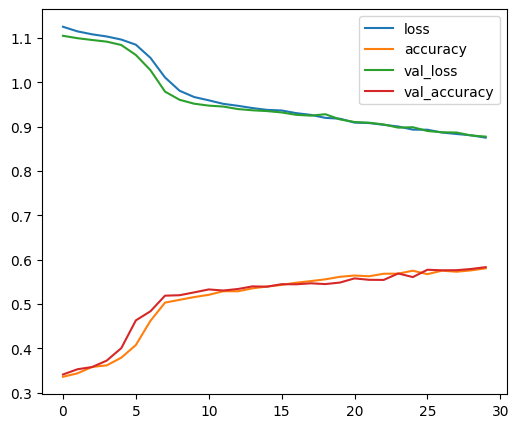

[[ 488  717  118]
 [ 243 1112   29]
 [ 188  394  765]]


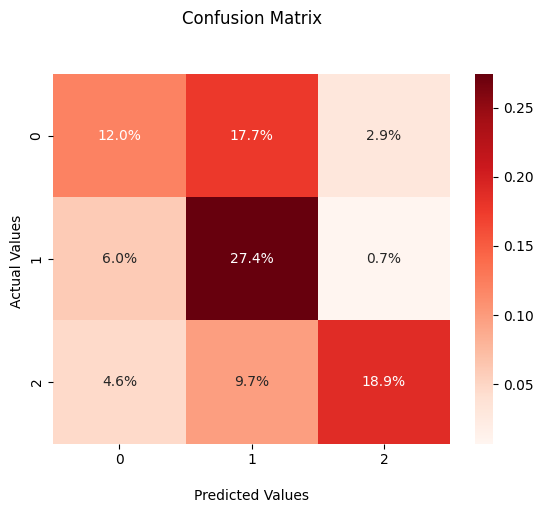

COMPILING...
32/32 [==============================] - 0s 5ms/step - loss: 0.8416 - accuracy: 0.6135
Score : loss of 0.8415845036506653; accuracy of 61.34681701660156%
127/127 [==============================] - 0s 2ms/step
F1 score:  0.5918720710468915
Precision:  0.6142647281255426
Recall:  0.6134681795757276


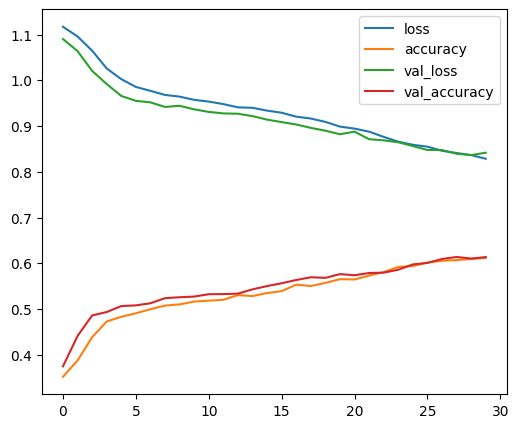

[[ 400  662  269]
 [ 165 1220   47]
 [ 167  257  867]]


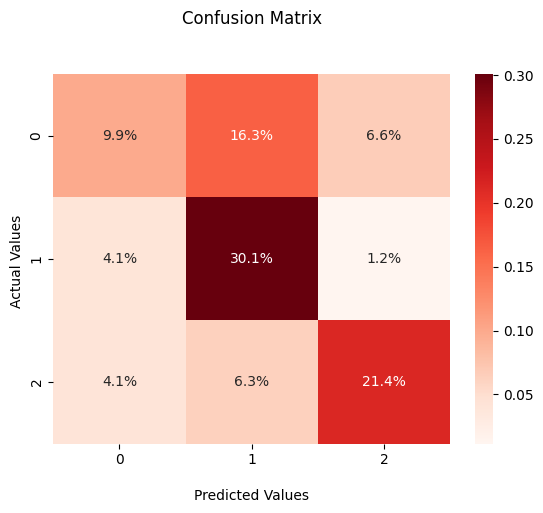

COMPILING...
32/32 [==============================] - 0s 5ms/step - loss: 0.8924 - accuracy: 0.5868
Score : loss of 0.892395555973053; accuracy of 58.682781457901%
127/127 [==============================] - 0s 2ms/step
F1 score:  0.5689959182551555
Precision:  0.6140068511789113
Recall:  0.5868278243709916


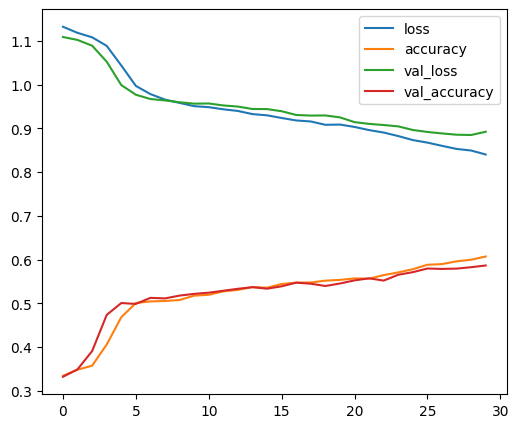

[[ 393  787  152]
 [ 138 1187   65]
 [ 185  348  799]]


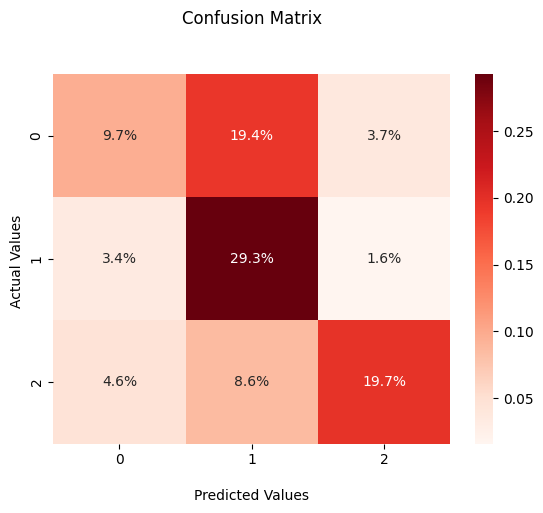

COMPILING...
32/32 [==============================] - 0s 6ms/step - loss: 0.8524 - accuracy: 0.5863
Score : loss of 0.8523539900779724; accuracy of 58.63344669342041%
127/127 [==============================] - 0s 2ms/step
F1 score:  0.5696740666651148
Precision:  0.5779561394725015
Recall:  0.5863344844597927


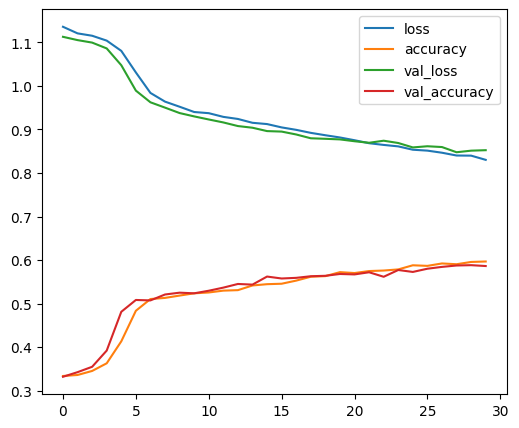

[[443 597 355]
 [248 953 134]
 [162 181 981]]


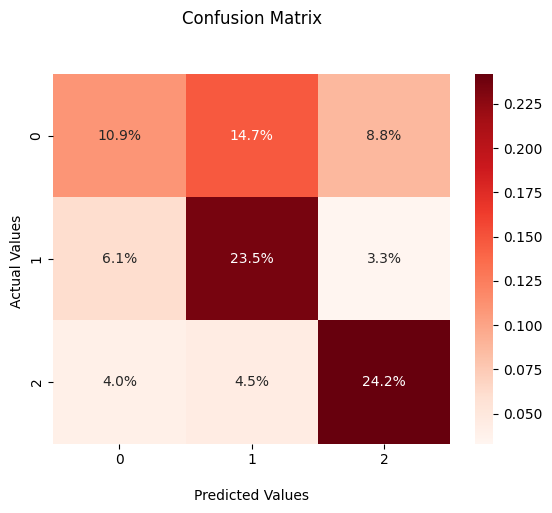

COMPILING...
32/32 [==============================] - 0s 6ms/step - loss: 0.8806 - accuracy: 0.5861
Score : loss of 0.8805608749389648; accuracy of 58.60878229141235%
127/127 [==============================] - 0s 2ms/step
F1 score:  0.5540786086264043
Precision:  0.6085752201930159
Recall:  0.5860878145041933


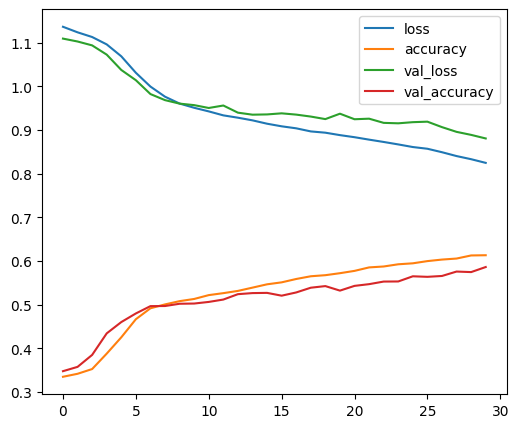

[[ 309  841  232]
 [ 105 1177   66]
 [ 124  310  890]]


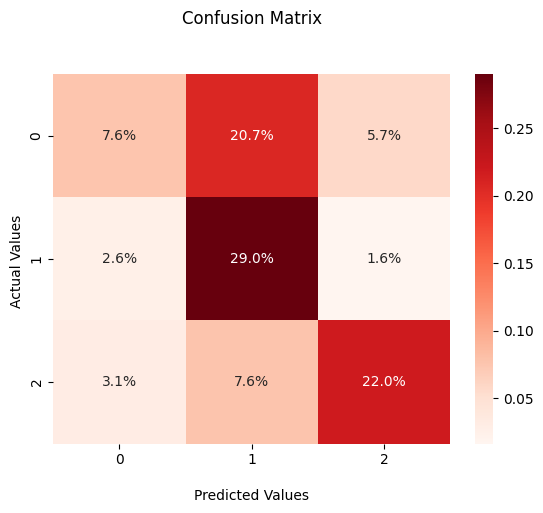

In [ ]:
X = {}
y = {}

X = np.concatenate([all_data[i]["data"] for i in range(len(all_data))])
y = np.concatenate([all_data[i]["label"] for i in range(len(all_data))])

transformers(X,y,5)

In [ ]:
all_scores_transf

[0.5833744406700134,
 0.6134681701660156,
 0.58682781457901,
 0.5863344669342041,
 0.5860878229141235]

In [ ]:
np.mean(all_scores_transf)

0.5912185430526733

In [ ]:
all_f1_transf

[0.5776003183989205,
 0.5918720710468915,
 0.5689959182551555,
 0.5696740666651148,
 0.5540786086264043]

In [ ]:
np.mean(all_f1_transf)

0.5724441965984973